# Квантовая нейронная сеть

## Обработка данных

Для начала нужно перевести наши данные в квантовые состояния. А для этого нужно привести данные в нужную размерность, буду использовать датасет https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay?resource=download.

Нашей меткой будет являтся Delay, который показывает будет ли задержан авиарейс. Считаем датасет.

In [57]:
import csv

dataset = []

with open("Airlines.csv", "r+", encoding="UTF-8") as f:
    reader = csv.reader(f)
    for i in reader:
        dataset.append(i[1:])
dataset, headers = dataset[1:], dataset[0]
headers, dataset[:5]

(['Airline',
  'Flight',
  'AirportFrom',
  'AirportTo',
  'DayOfWeek',
  'Time',
  'Length',
  'Delay'],
 [['CO', '269', 'SFO', 'IAH', '3', '15', '205', '1'],
  ['US', '1558', 'PHX', 'CLT', '3', '15', '222', '1'],
  ['AA', '2400', 'LAX', 'DFW', '3', '20', '165', '1'],
  ['AA', '2466', 'SFO', 'DFW', '3', '20', '195', '1'],
  ['AS', '108', 'ANC', 'SEA', '3', '30', '202', '0']])

Теперь переведем все признаки в целочисленные данные и отделим метки.

In [58]:
labels = [int(i[7]) for i in dataset]
labels[:5]

[1, 1, 1, 1, 0]

In [59]:
d0 = {i:j for j,i in enumerate(set([i[0] for i in dataset]))}
d2 = {i:j for j,i in enumerate(set([i[2] for i in dataset]))}
d3 = {i:j for j,i in enumerate(set([i[3] for i in dataset]))}

dataset = [ [d0[d[0]], int(d[1]), d2[d[2]], d3[d[3]], int(d[4]), int(d[5]), int(d[6])] for d in dataset]
dataset[:5]

[[3, 269, 128, 262, 3, 15, 205],
 [9, 1558, 100, 63, 3, 15, 222],
 [8, 2400, 200, 66, 3, 20, 165],
 [8, 2466, 128, 66, 3, 20, 195],
 [6, 108, 187, 43, 3, 30, 202]]

Так как в четырехчастичную систему кубитов можно представить имея 2^(n+1)-2 параметров, то нам нужны вектора с размерностью 6(2^(2+1) - 2 = 8). Использую метод обобщенной сериализации через библиотеку genser.

In [60]:
from genser import transform_to

ds6 = transform_to(dataset, 6)[0]

Теперь переведем все данные в квантовые состояния

In [61]:
from math import cos, sin, pi
from functools import reduce
from cmath import rect
from genser import *
from math import cos, sin, pi, log2
from cmath import rect
from functools import reduce
from quantumz import *


def truebin(n,b): # служебная функция
    bn = bin(n)[2:]
    return '0'*(b-len(bn))+bn


def powers(DS): # вычисляет мощности признаков в датасете
    tDS = [[d[p] for d in DS] for p,_ in enumerate(DS[0])]
    return [max(ti)+1 for ti in tDS]


def Z_to_Q(data): # трансформирует датасет (без меток) в квантовые состояния - размерность данных должна быть подходящей!
    n = int(len(data[0])/2)
    P = powers(data)
    zdata = []
    for d in data:
        delta = [d[i]/(P[i]-1)*pi/2 for i in range(n)]
        gamma = [d[i+n]/P[i+n]*pi*2 for i in range(n)]
        zl = [reduce(lambda a, b: a*b, [cos(delta[j]) for j in range(n)])]
        for i in range(1,n):
            zl.append(sin(delta[i-1])*reduce(lambda a, b: a*b, [cos(delta[j]) for j in range(i,n)])*rect(1,gamma[i-1]))
        zl.append(sin(delta[n-1])*rect(1,gamma[n-1]))
        qzl = {'|'+truebin(i,int(log2(n+1)))+'>':z for i,z in enumerate(zl)}
        zdata.append(qzl)
    return zdata

In [62]:
qds = Z_to_Q(ds6)[:1000]
qds_train, l_train = qds, labels
qds_train[0]

{'|00>': 0.7373651695049538,
 '|01>': (0.17735270951247767-0.13900599943725875j),
 '|10>': (0.04164487837299883+0.0027295495370857673j),
 '|11>': (-0.24316941394029956+0.5870628970889884j)}

## Построение нейронной сети

Будем строить простейшую КНС(квантовую нейронную сеть), состоящую из одного нейрона.

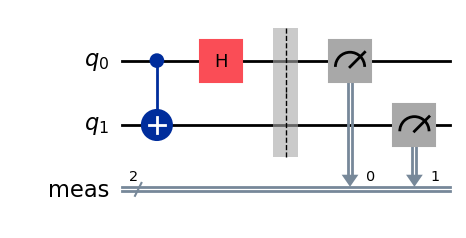

In [63]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

# Создание квантовой схемы с 3 кубитами и 2 классическими битами
qc = QuantumCircuit(2, 0)

# Строим нейрон
qc.cx(0, 1)
qc.h(0)

qc.measure_all()

# Симуляция схемы
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()

# Визуализация схемы и гистограммы
qc.draw(output='mpl')


In [64]:
from dsmltf import f1_score

def f1(D, K) -> float:
    fp, fn, tp = 0, 0, 0
    for i in D[0]:
        fp += K[1][i]
    for i in D[1]:
        fn += K[0][i]
        tp += K[1][i]
    return f1_score(tp, fp, fn)

In [65]:
from genser import *
from quantumz import *
from random import random


def QN(inp_qvect,cl_outs_num): # один квантовый нейрон с заданным числом классических выходов (второй аргумент)
    qn = len(list(inp_qvect.keys())[0])-2
    qvect = dict(inp_qvect)
    for k in range(qn-1):
        qvect = CX(qvect,[qn-k-2],qn-k-1)
    qvect = H(qvect,0)
    mes, res = multi_measure(qvect, list(range(cl_outs_num)))
    return mes, res


def shot(res_dict): # получение числа из заданного квантового состояния одним измерением
    dn = len(list(res_dict.keys())[0])-2
    dimn = 2**dn
    x = random()
    s,v = 0,dimn-1
    for k in range(dimn):
        kd = '|'+truebin(k,dn)+'>'
        if kd in res_dict.keys():
            s += res_dict[kd]
            if s>x:
                v = k
                break
    return v


def train(tdata,labels): # статистическое обучение нейрона
    dn = len(list(tdata[0].keys())[0])-2
    dimn = 2**dn
    D = {0:[],1:[]}
    K = [[0 for _ in range(dimn)],[0 for _ in range(dimn)]]
    # Повторить шаги для всех экземпляров
    for td,tl in zip(tdata,labels):
        # Пропустить экземпляр данных через КНС и получить результат измерений .
        q = QN(td, dn)
        # print(q[0])
        v = shot(q[0])
        # Увеличить значение Kva на 1.
        K[tl][v] += 1
    # вычисление по формулам (6) и (7) из DANI0177
    ke0 = [K[0][ki]/(K[0][ki]+K[1][ki]) if (K[0][ki]+K[1][ki]) else 0 for ki in range(dimn)]
    ke0 = [(k-min(ke0))/(max(ke0)-min(ke0)) for k in ke0]
    ke1 = [K[1][ki]/(K[0][ki]+K[1][ki]) if (K[0][ki]+K[1][ki]) else 0 for ki in range(dimn)]
    ke1 = [(k-min(ke1))/(max(ke1)-min(ke1)) for k in ke1]
    # кол-во истин
    keb = sum(labels)/len(labels)
    # кол-во ложей
    kea = 1-keb
    # частота появления самой распространенной метки
    ke_max = max(kea,keb)
    # сопоставим список значений – чисел – таких, при которых нормированная частота превышает частоту появления
    # самой распространенной метки
    kec = [0 if k0>ke_max else (1 if k1>ke_max else -1) for k0,k1 in zip(ke0,ke1)]
    for v,k in enumerate(kec): 
        if k>0:
            D[1].append(v)
        elif not k:
            D[0].append(v)
    return D,K # D - словарь с ключами 0 и 1 и значениями - списками результатов измерений, K - список из двух списков (каждый - сколько и каких результатов было)

In [66]:
# учим нейрон
D,K = train(qds_train[:-1],l_train[:-1])
D

{0: [0, 1, 3], 1: [2]}

In [67]:
K

[[292, 167, 197, 133], [73, 39, 65, 33]]

In [68]:
f1(D, K)

0.2754237288135593